In [1]:
# Import Pandas and Numpy
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# Reading and creating directories
import os

# Ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")

# Progress bar
from tqdm import tqdm

# Reload modules
%load_ext autoreload
%autoreload 2

# Import Socceraction modules to manipulate StatsBomb open data
import socceraction.spadl as spadl

# Import jenkspy to perform 1-D clustering
from jenkspy import JenksNaturalBreaks

# Library for computing if two line segments intersect
from shapely.geometry import LineString

# Data Visualization libraries
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load line breaking Data
passes = pd.read_csv('euro2020_passes.csv')

# Line Breaking Pass Visualization

In [3]:
# Find one line breaking pass
lb = passes[passes['line_breaking'] == True].copy()
lb.reset_index(inplace = True)
lb_pass = lb.loc[10:10]

#Save game_id of the pass
game_id = int(lb_pass.game_id)

In [4]:
# Load Frame Data
datafolder = r"C:\Users\alber\Statsbomb"
spadl_h5 = os.path.join(datafolder, "euro2020.h5")

# Open data
with pd.HDFStore(spadl_h5) as spadlstore:
    frames = spadlstore[f"frames/game_{game_id}"]

In [5]:
# Merge lb_pass with the corresponding event in the SB360 frames
df_360 = lb_pass.merge(frames, how = 'left', left_on = 'original_event_id', right_on = 'id' ).copy()
                
# Exclude passer's teammates
df_360_opp = df_360[df_360.teammate == False].copy()

# Exclude the goalkeeper
df_360_opp = df_360_opp[df_360_opp.keeper == False]

# Check if there are at least 2 defenders 
if len(df_360_opp) >=2:

    # The defensive lines, the ones that we want to check if they're broken by the pass,
    # will be identified with a 1-D clustering on the x-dimension of the pitch. 
    # 1-D Clustering = Fisher-Jenks algorithm

    # Find the x-values
    x = list(df_360_opp.loc_x)

    # If the number of values (i.e. the number of defenders in the 360-frames) are more than 4
    # find 3 defensive lines
    if len(x)>4:

        # Create the model for 3 clusters
        jnb = JenksNaturalBreaks(nb_class = 3)

        # Fit the model
        jnb.fit(x)

        # Predict the cluster (i.e. line)
        df_360_opp['group'] = jnb.labels_

    # If the number of defenders is 4, consider 2 clusters.
    elif len(x)>3:

        # Create the model for 2 clusters, fit and label the values
        jnb = JenksNaturalBreaks(nb_class = 2)
        jnb.fit(x)
        df_360_opp['group'] = jnb.labels_

    # If there are 2 or 3 defenders in the frames, label all the defenders in the same group
    else:
        df_360_opp['group'] = 0

        # If there are 2 or 3 defenders we want to be sure that they are close
        # to each other in the x-direction since we label them in the same
        # Create a function that computes the distance between players
        def dx(row):
            k = list(df_360_opp.loc_x)
            ind = k.index(float(row['loc_x']))
            z = k[:ind] + k[ind+1:]
            return min([abs(w-k[ind]) for w in z ])
        df_360_opp['dx'] = df_360_opp.apply(dx, axis = 1)

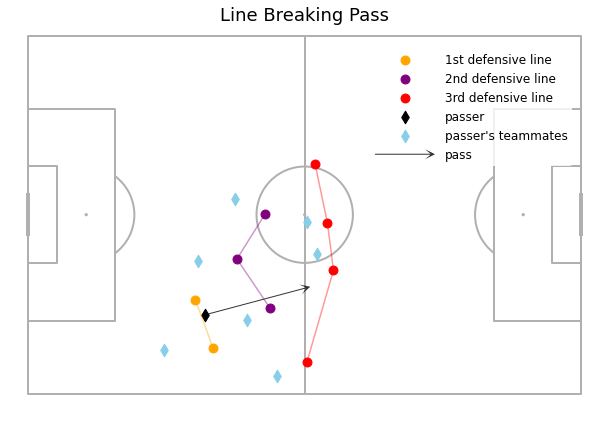

In [6]:
# Import mplsoccer 
from mplsoccer import Pitch

# Create pitch plot object
pitch = Pitch()
pitch = Pitch(pitch_type='custom', pitch_length=105, pitch_width=68)

# Create the plot and associate it with pitch
fig, ax = pitch.draw(figsize=(12, 6))

# Filter teammates and find the passes
df_com = df_360[(df_360.teammate == True) & (df_360.actor == False)]
df_ac = df_com[df_com.actor == True]

# Plot first line of defenders
# Check if there are defenders in the first group
if len(df_360_opp[(df_360_opp.group == 0)])>0:
    
    # Plot the defenders 
    scatter = pitch.scatter(df_360_opp[(df_360_opp.group == 0)].loc_x, df_360_opp[(df_360_opp.group == 0)].loc_y, 
                            ax=ax, edgecolor='orange', facecolor='orange', s= 80, label = '1st defensive line')
    
    # Order the defenders in the y-direction
    df_0 = df_360_opp[(df_360_opp.group == 0)].sort_values('loc_y', ascending = False).copy()
    df_0.reset_index(inplace = True)
    
    # Plot the defensive lines
    i = 0
    while i<len(df_0)-1:
        plt.plot([df_0.iloc[i].loc_x,df_0.iloc[i+1].loc_x],[df_0.iloc[i].loc_y,df_0.iloc[i+1].loc_y], 
                 color = 'orange',alpha = 0.4)
        i+=1
        
    
# Plot the second line of defenders
# Check if there are defenders in the second group    
if len(df_360_opp[(df_360_opp.group == 1)])>0:

    # Plot the defenders 
    scatter = pitch.scatter(df_360_opp[(df_360_opp.group == 1)].loc_x, df_360_opp[(df_360_opp.group == 1)].loc_y, 
                            ax=ax, edgecolor='purple', facecolor='purple', s = 80, label = '2nd defensive line')
    
    # Order the defenders in the y-direction
    df_1 = df_360_opp[(df_360_opp.group == 1)].sort_values('loc_y', ascending = False).copy()
    df_1.reset_index(inplace = True)
    
    # Plot the defensive lines
    i = 0 
    while i<len(df_1)-1:
        plt.plot([df_1.iloc[i].loc_x,df_1.iloc[i+1].loc_x],[df_1.iloc[i].loc_y,df_1.iloc[i+1].loc_y], 
                 color = 'purple',alpha = 0.4)
        i+=1

# Plot the third line of defenders
# Check if there are defenders in the second group    
if len(df_360_opp[(df_360_opp.group == 2)])>0:
    
    # Plot the defenders
    scatter = pitch.scatter(df_360_opp[(df_360_opp.group == 2)].loc_x, df_360_opp[(df_360_opp.group == 2)].loc_y, 
                            ax=ax, edgecolor='red', facecolor='red', s = 80, label = '3rd defensive line')
    
    # Order the defenders in the y-direction
    df_2 = df_360_opp[(df_360_opp.group == 2)].sort_values('loc_y', ascending = False).copy()
    df_2.reset_index(inplace = True)
    
    # Plot the defensive lines
    i = 0 
    while i<len(df_2)-1:
        plt.plot([df_2.iloc[i].loc_x,df_2.iloc[i+1].loc_x],[df_2.iloc[i].loc_y,df_2.iloc[i+1].loc_y], 
                 color = 'red',alpha = 0.4)
        i+=1


#Plot the passer
scatter = pitch.scatter(lb_pass.start_x, lb_pass.start_y, ax=ax, edgecolor='black', facecolor='black', s = 80, 
                        marker = 'd', label = 'passer')


# Plot passer's teammates             
scatter = pitch.scatter(df_com.loc_x, df_com.loc_y, ax=ax, edgecolor='skyblue', facecolor='skyblue', s = 80, 
                       label = 'passer\'s teammates', marker = 'd')

# Plot the passer
pitch.arrows(float(lb_pass.start_x), float(lb_pass.start_y), float(lb_pass.end_x), float(lb_pass.end_y),
        width=1, headwidth=10, headlength=10, ax = ax, linestyle = '-', color = 'black', alpha = 0.8, label ='pass')

# Set legend             
ax.legend( handlelength=5, edgecolor='None', fontsize=12, loc='best', bbox_to_anchor=(0.6, 0.53, 0.6, 0.4))

# Make title
plt.title('Line Breaking Pass', size = 18, y = 0.97)

# Show the plot
plt.show()

# Non line pass breaking pass visualization

In [7]:
# Find a non line breaking pass
nlb = passes[(passes['line_breaking'] == False)].copy()
nlb.reset_index(inplace = True)
nlb_pass = nlb.loc[404:404]

#Save game_id of the pass
game_id = int(nlb_pass.game_id)

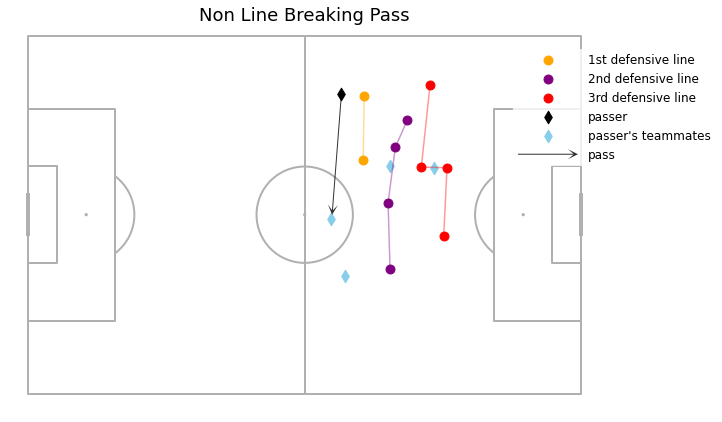

In [8]:
# Merge nlb_pass with the corresponding event in the SB360 frames
df_360 = nlb_pass.merge(frames, how = 'left', left_on = 'original_event_id', right_on = 'id' ).copy()
                
# Exclude passer's teammates
df_360_opp = df_360[df_360.teammate == False].copy()

# Exclude the goalkeeper
df_360_opp = df_360_opp[df_360_opp.keeper == False]

# Check if there are at least 2 defenders 
if len(df_360_opp) >=2:

    # The defensive lines, the ones that we want to check if they're broken by the pass,
    # will be identified with a 1-D clustering on the x-dimension of the pitch. 
    # 1-D Clustering = Fisher-Jenks algorithm

    # Find the x-values
    x = list(df_360_opp.loc_x)

    # If the number of values (i.e. the number of defenders in the 360-frames) are more than 4
    # find 3 defensive lines
    if len(x)>4:

        # Create the model for 3 clusters
        jnb = JenksNaturalBreaks(nb_class = 3)

        # Fit the model
        jnb.fit(x)

        # Predict the cluster (i.e. line)
        df_360_opp['group'] = jnb.labels_

    # If the number of defenders is 4, consider 2 clusters.
    elif len(x)>3:

        # Create the model for 2 clusters, fit and label the values
        jnb = JenksNaturalBreaks(nb_class = 2)
        jnb.fit(x)
        df_360_opp['group'] = jnb.labels_

    # If there are 2 or 3 defenders in the frames, label all the defenders in the same group
    else:
        df_360_opp['group'] = 0

        # If there are 2 or 3 defenders we want to be sure that they are close
        # to each other in the x-direction since we label them in the same
        # Create a function that computes the distance between players
        def dx(row):
            k = list(df_360_opp.loc_x)
            ind = k.index(float(row['loc_x']))
            z = k[:ind] + k[ind+1:]
            return min([abs(w-k[ind]) for w in z ])
        df_360_opp['dx'] = df_360_opp.apply(dx, axis = 1)
        

# Import mplsoccer 
from mplsoccer import Pitch

# Create pitch plot object
pitch = Pitch()
pitch = Pitch(pitch_type='custom', pitch_length=105, pitch_width=68)

# Create the plot and associate it with pitch
fig, ax = pitch.draw(figsize=(12, 6))

# Filter teammates and find the passes
df_com = df_360[(df_360.teammate == True) & (df_com.actor == False)]
df_ac = df_com[df_com.actor == True]

# Plot first line of defenders
# Check if there are defenders in the first group
if len(df_360_opp[(df_360_opp.group == 0)])>0:
    
    # Plot the defenders 
    scatter = pitch.scatter(df_360_opp[(df_360_opp.group == 0)].loc_x, df_360_opp[(df_360_opp.group == 0)].loc_y, 
                            ax=ax, edgecolor='orange', facecolor='orange', s= 80, label = '1st defensive line')
    
    # Order the defenders in the y-direction
    df_0 = df_360_opp[(df_360_opp.group == 0)].sort_values('loc_y', ascending = False).copy()
    df_0.reset_index(inplace = True)
    
    # Plot the defensive lines
    i = 0
    while i<len(df_0)-1:
        plt.plot([df_0.iloc[i].loc_x,df_0.iloc[i+1].loc_x],[df_0.iloc[i].loc_y,df_0.iloc[i+1].loc_y], 
                 color = 'orange',alpha = 0.4)
        i+=1
        
    
# Plot the second line of defenders
# Check if there are defenders in the second group    
if len(df_360_opp[(df_360_opp.group == 1)])>0:

    # Plot the defenders 
    scatter = pitch.scatter(df_360_opp[(df_360_opp.group == 1)].loc_x, df_360_opp[(df_360_opp.group == 1)].loc_y, 
                            ax=ax, edgecolor='purple', facecolor='purple', s = 80, label = '2nd defensive line')
    
    # Order the defenders in the y-direction
    df_1 = df_360_opp[(df_360_opp.group == 1)].sort_values('loc_y', ascending = False).copy()
    df_1.reset_index(inplace = True)
    
    # Plot the defensive lines
    i = 0 
    while i<len(df_1)-1:
        plt.plot([df_1.iloc[i].loc_x,df_1.iloc[i+1].loc_x],[df_1.iloc[i].loc_y,df_1.iloc[i+1].loc_y], 
                 color = 'purple',alpha = 0.4)
        i+=1

# Plot the third line of defenders
# Check if there are defenders in the second group    
if len(df_360_opp[(df_360_opp.group == 2)])>0:
    
    # Plot the defenders
    scatter = pitch.scatter(df_360_opp[(df_360_opp.group == 2)].loc_x, df_360_opp[(df_360_opp.group == 2)].loc_y, 
                            ax=ax, edgecolor='red', facecolor='red', s = 80, label = '3rd defensive line')
    
    # Order the defenders in the y-direction
    df_2 = df_360_opp[(df_360_opp.group == 2)].sort_values('loc_y', ascending = False).copy()
    df_2.reset_index(inplace = True)
    
    # Plot the defensive lines
    i = 0 
    while i<len(df_2)-1:
        plt.plot([df_2.iloc[i].loc_x,df_2.iloc[i+1].loc_x],[df_2.iloc[i].loc_y,df_2.iloc[i+1].loc_y], 
                 color = 'red',alpha = 0.4)
        i+=1


#Plot the passer
scatter = pitch.scatter(nlb_pass.start_x, nlb_pass.start_y, ax=ax, edgecolor='black', facecolor='black', s = 80, 
                        marker = 'd', label = 'passer')


# Plot passer's teammates             
scatter = pitch.scatter(df_com.loc_x, df_com.loc_y, ax=ax, edgecolor='skyblue', facecolor='skyblue', s = 80, 
                       label = 'passer\'s teammates', marker = 'd')

# Plot the passer
pitch.arrows(float(nlb_pass.start_x), float(nlb_pass.start_y), float(nlb_pass.end_x), float(nlb_pass.end_y),
        width=1, headwidth=10, headlength=10, ax = ax, linestyle = '-', color = 'black', alpha = 0.8, label ='pass')

# Set legend             
ax.legend( handlelength=5, edgecolor='None', fontsize=12, loc='best', bbox_to_anchor=(0.6, 0.53, 0.6, 0.4))

# Make title
plt.title('Non Line Breaking Pass', size = 18, y = 0.97)

# Show the plot
plt.show()